In [1]:
from fastai.vision.all import *
from functools import reduce

## Gather Dataset

In [2]:
data_set_length = 10

In [3]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

### Define training dataset

In [4]:
training_paths = [(path/f'training/{num}').ls().sorted() for num in range(data_set_length)]
training_tensors = [[tensor(Image.open(im)) for im in path] for path in training_paths]
training_stacked_digits = [torch.stack(tensors)/255 for tensors in training_tensors]

### Define testing dataset

In [5]:
test_paths = [(path/f'testing/{num}').ls().sorted() for num in range(data_set_length)]
test_tensors = [[tensor(Image.open(im)) for im in path] for path in test_paths]
test_stacked_digits = [torch.stack(tensors)/255 for tensors in test_tensors]

In [6]:
len(test_stacked_digits[0])

980

## Pixel similarity approach

### Get The average look of each digit

In [7]:
empty_lists = [[] for _ in range(data_set_length)]
mean_list = [train_set.mean(0) for train_set in training_stacked_digits]

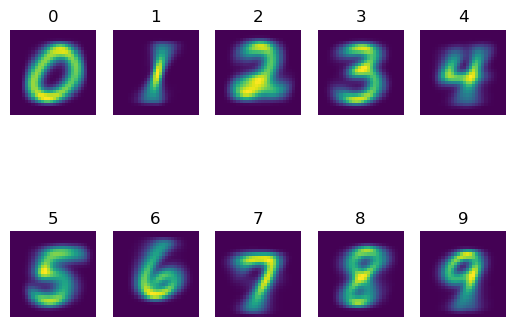

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(0, 5):
  show_image(mean_list[i], ax=ax[0][i], title=i)
  show_image(mean_list[i+5], ax=ax[1][i], title=i+5)

## Make Prediction

In [9]:
def predict(tensor,mean_list_copy,index):
    distance_difference = F.mse_loss(tensor,mean_list_copy.pop(index)).sqrt()
    for mean in mean_list_copy:
        second_distance_difference = F.mse_loss(tensor,mean).sqrt()
        if second_distance_difference <= distance_difference:
            return False
    return True

In [10]:
empty_lists = [[] for _ in range(data_set_length)]
predictions = [torch.tensor(lst) for lst in empty_lists]
for index, test_stack in enumerate(test_stacked_digits):
    for tensor in test_stack:
        loss = predict(tensor,copy(mean_list),index)
        predictions[index] = torch.cat((predictions[index], torch.tensor([loss])))

## Show Accuracy

In [11]:
print("individual accuracy")
accuracy = [prediction.mean() for prediction in predictions]
for index, acc in enumerate(accuracy):
    print(f'{index}:{acc}')
print(f'Total accuracy: {torch.tensor(accuracy).mean()}')

individual accuracy
0:0.8959183692932129
1:0.9621145129203796
2:0.7567829489707947
3:0.805940568447113
4:0.8258655667304993
5:0.6860986351966858
6:0.8632568120956421
7:0.8326848149299622
8:0.7371663451194763
9:0.806739330291748
Total accuracy: 0.8172568082809448


## Deep learning approach
1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be the correct label.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

### Define the training set

In [12]:
training_digits = torch.cat(training_stacked_digits).view(-1, 28*28)
label_list = [[index] * len(digit) for index,digit in enumerate(training_stacked_digits)]
training_labels = torch.tensor((reduce(lambda x,y: x + y, label_list)))
training_dataset = list(zip(training_digits,training_labels))
training_dl = DataLoader(training_dataset,batch_size=256)

In [13]:
first(training_dl)[0].shape,first(training_dl)[1].shape

(torch.Size([256, 784]), torch.Size([256]))

### Define the test test

In [14]:
test_digits = torch.cat(test_stacked_digits).view(-1, 28*28)
label_list  = [[index] * len(digit) for index,digit in enumerate(test_stacked_digits)]
test_labels = torch.tensor(reduce(lambda x,y: x + y, label_list))
test_datasest = list(zip(test_digits,test_labels))
test_dl = DataLoader(test_datasest,batch_size=256)

In [15]:
first(test_dl)[0].shape,first(test_dl)[1].shape

(torch.Size([256, 784]), torch.Size([256]))

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
class Optimizer:
    def __init__(self,init_params,learning_rate):
        self.params, self.learning_rate = list(init_params),learning_rate

    def calculate_gradient(self, training_set, labels, model):
        predictions = model(training_set)
        loss = criterion(predictions,labels)
        loss.backward()

    def batch_accuracy(self,pred, actual):
        digit_pred = pred.max(dim=1)[1]
        return (digit_pred==actual).float().mean()

    def step(self):
        for p in self.params:
            p.data -= p.grad * self.learning_rate
            p.grad.zero_()

    def validate_epoch(self, model,test_dl):
        accuracy = []
        with torch.no_grad():
          accuracy = [self.batch_accuracy(model(digits), label) for digits,label in test_dl ]
        return round(torch.stack(accuracy).mean().item(), 4)

In [18]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
opt = Optimizer(simple_net.parameters(),1e-3)

In [19]:
def train_epoch(model):
    for x,y in training_dl:
        opt.calculate_gradient(x,y,model)
        opt.step()

In [20]:
def train_model(model,epoch):
    for i in range(epoch):
        train_epoch(model)
        print(f'Current epoch:{i} Accuracy:{opt.validate_epoch(model,test_dl)}')

In [21]:
train_model(simple_net,100)

Current epoch:0 Accuracy:0.168
Current epoch:1 Accuracy:0.3422
Current epoch:2 Accuracy:0.4764
Current epoch:3 Accuracy:0.5399
Current epoch:4 Accuracy:0.5869
Current epoch:5 Accuracy:0.6255
Current epoch:6 Accuracy:0.6443
Current epoch:7 Accuracy:0.6595
Current epoch:8 Accuracy:0.6629
Current epoch:9 Accuracy:0.6729
Current epoch:10 Accuracy:0.6782
Current epoch:11 Accuracy:0.684
Current epoch:12 Accuracy:0.6886
Current epoch:13 Accuracy:0.6954
Current epoch:14 Accuracy:0.7019
Current epoch:15 Accuracy:0.708
Current epoch:16 Accuracy:0.7139
Current epoch:17 Accuracy:0.7215
Current epoch:18 Accuracy:0.7294
Current epoch:19 Accuracy:0.7371
Current epoch:20 Accuracy:0.7454
Current epoch:21 Accuracy:0.7517
Current epoch:22 Accuracy:0.7579
Current epoch:23 Accuracy:0.765
Current epoch:24 Accuracy:0.7706
Current epoch:25 Accuracy:0.7754
Current epoch:26 Accuracy:0.7809
Current epoch:27 Accuracy:0.7859
Current epoch:28 Accuracy:0.7905
Current epoch:29 Accuracy:0.7941
Current epoch:30 Accurac